In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
        '/content/cats_and_dogs',
        classes=['test'],
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


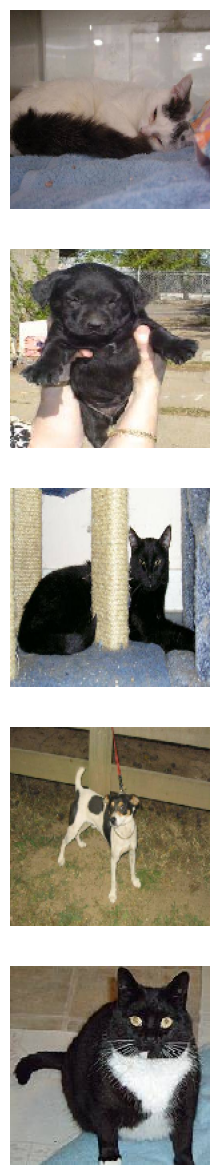

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2)

Found 2000 images belonging to 2 classes.


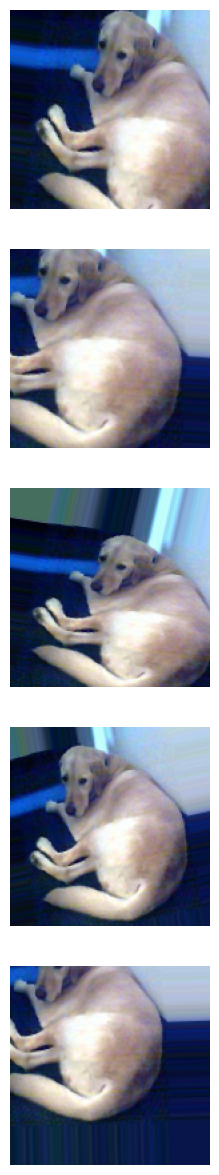

In [6]:
train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 128)               43655296  
                                                        

In [8]:
history = model.fit(
        x=train_data_gen,
        steps_per_epoch=16,
        epochs=50,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size)

Epoch 1/50
16/16 [==============================] - 31s 1s/step - loss: 3.3464 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5134
Epoch 2/50
16/16 [==============================] - 18s 1s/step - loss: 0.6931 - accuracy: 0.5185 - val_loss: 0.6927 - val_accuracy: 0.5056
Epoch 3/50
16/16 [==============================] - 17s 1s/step - loss: 0.6857 - accuracy: 0.5505 - val_loss: 0.6743 - val_accuracy: 0.5246
Epoch 4/50
16/16 [==============================] - 17s 1s/step - loss: 0.6749 - accuracy: 0.5745 - val_loss: 0.6477 - val_accuracy: 0.5781
Epoch 5/50
16/16 [==============================] - 17s 1s/step - loss: 0.6635 - accuracy: 0.5800 - val_loss: 0.6295 - val_accuracy: 0.5882
Epoch 6/50
16/16 [==============================] - 16s 991ms/step - loss: 0.6497 - accuracy: 0.6210 - val_loss: 0.6540 - val_accuracy: 0.5737
Epoch 7/50
16/16 [==============================] - 17s 1s/step - loss: 0.6496 - accuracy: 0.6220 - val_loss: 0.6343 - val_accuracy: 0.6350
Epoch 8/50
16/16 

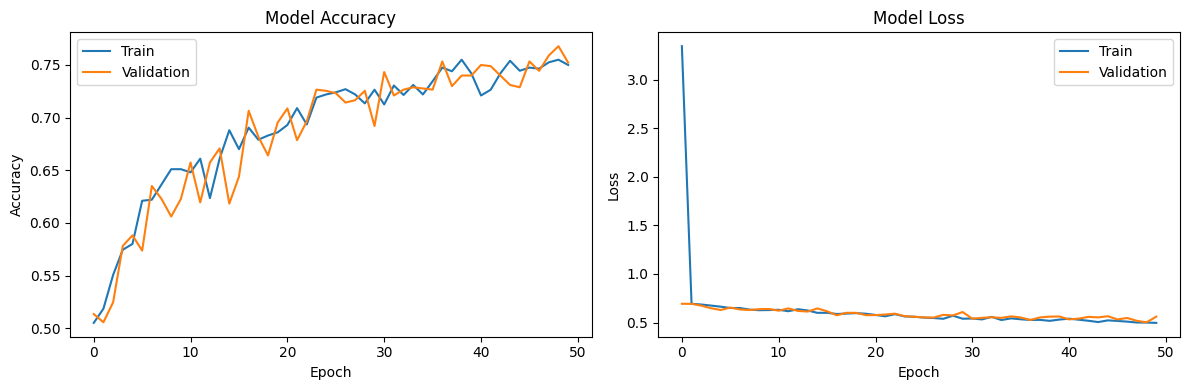

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 204ms/step


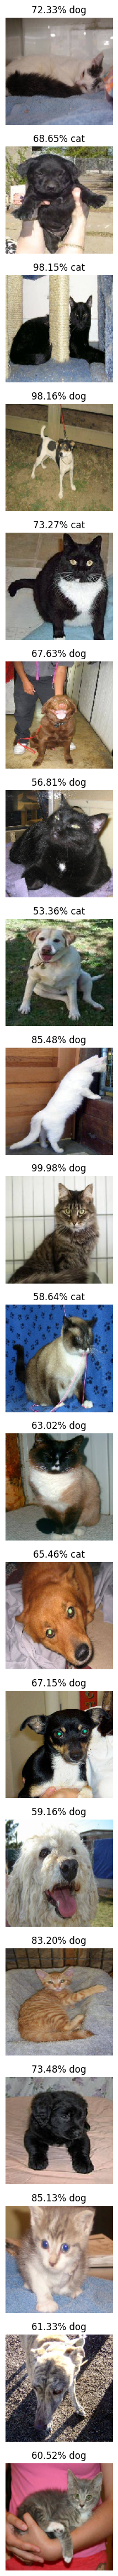

In [14]:
probabilities = model.predict(test_data_gen)
plotImages(sample_training_images[:20], probabilities)

In [16]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
